<a href="https://colab.research.google.com/github/Kenzi-GIT/PCD_Assignment03/blob/main/PCD_Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kenji Ratanaputra - 24/534421/PA/22664
Implement one of the segmentation methods and several operation of morphological methods without using library. Comparing the segmentation result with and without applying morphological processing.




# 1. Import Libraries & Image


In [37]:
!rm -rf PCD_Assignment03
!git clone https://github.com/Kenzi-GIT/PCD_Assignment03

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow

Cloning into 'PCD_Assignment03'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (11/11), 200.19 KiB | 3.57 MiB/s, done.


# 2. Data Preparation

Original Image (RGB):


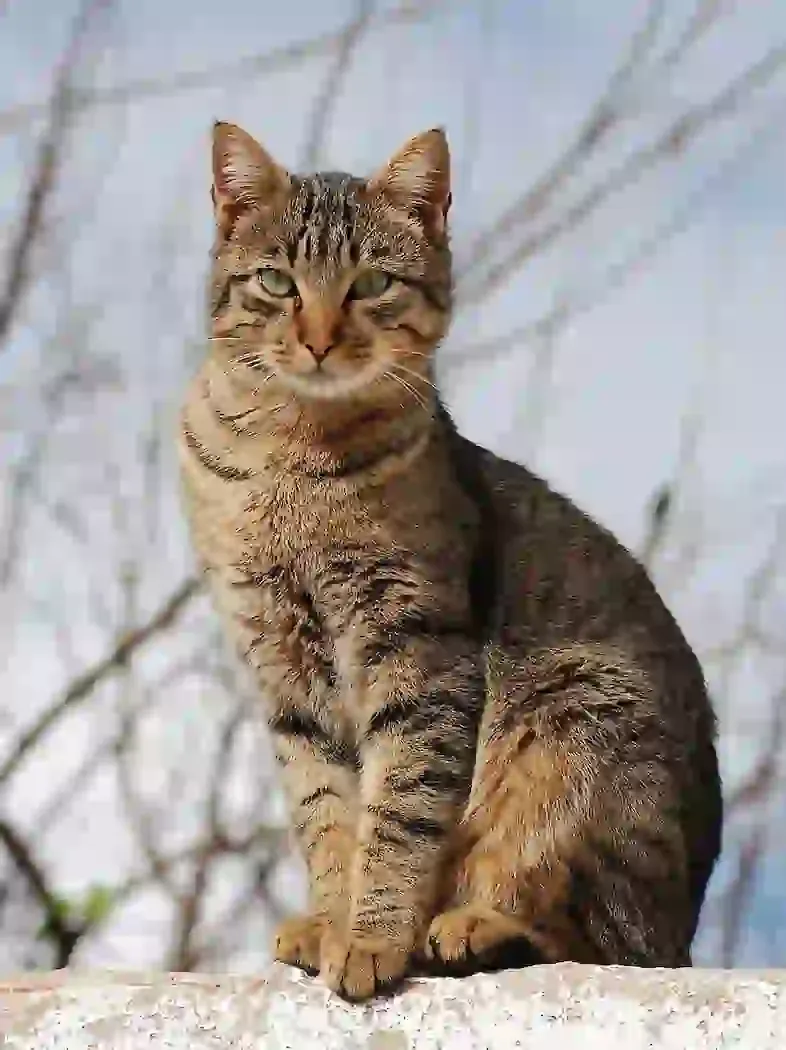

In [38]:
# Image Preparation
original = "/content/PCD_Assignment03/Original.webp"
original_img = cv2.imread(original)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

print("Original Image (RGB):")
cv2_imshow(cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR))

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)

def show(before, segmented=None, processed=None, title1="Original", title2="Segmented", title3="Processed"):
    plt.figure(figsize=(15, 5))

    # Show original
    plt.subplot(1, 3, 1)
    plt.imshow(before, cmap='gray', vmin=0, vmax=255)
    plt.title(title1)
    plt.axis("off")

    # Show segmented
    plt.subplot(1, 3, 2)
    plt.imshow(segmented, cmap='gray', vmin=0, vmax=255)
    plt.title(title2)
    plt.axis("off")

    # Show processed
    plt.subplot(1, 3, 3)
    plt.imshow(processed, cmap='gray', vmin=0, vmax=255)
    plt.title(title3)
    plt.axis("off")

    plt.show()

# 3. Segmentation Method
1.   Otsu Method




In [39]:
def otsu_threshold(img):
    histogram = np.zeros(256, dtype=int)
    for pixel_value in img.flatten():
        histogram[pixel_value] += 1

    total_pixels = img.size
    current_sum = sum(i * histogram[i] for i in range(256))
    sum_background = 0
    weight_background = 0
    max_variance = 0
    threshold = 0

    # Try every threshold value from 0-255
    for t in range(256):
        weight_background += histogram[t]
        if weight_background == 0:
            continue

        weight_foreground = total_pixels - weight_background
        if weight_foreground == 0:
            break

        sum_background += t * histogram[t]
        mean_background = sum_background / weight_background
        mean_foreground = (current_sum - sum_background) / weight_foreground


        variance = (weight_background * weight_foreground * (mean_background - mean_foreground) ** 2)

        if variance > max_variance:
            max_variance = variance
            threshold = t

    return threshold

def segment(image, threshold):
    segmented_image = np.zeros(image.shape, dtype=np.uint8)
    row, col = image.shape

    for r in range(row):
        for c in range(col):
            if image[r, c] > threshold:
                segmented_image[r, c] = 255
            else:
                segmented_image[r, c] = 0

    return segmented_image

optimal_threshold = otsu_threshold(gray_img)
print(f"\nOptimal Threshold: {optimal_threshold}")
segmented_img = segment(gray_img, optimal_threshold)


Optimal Threshold: 130


# 4. Morphological Operation

# **Erosion**
Erosi adalah kebalikan dari dilasi, yaitu proses morfologi yang berfungsi untuk mengikis atau memperkecil area foreground dengan menghapus piksel pada tepi objek. Proses ini dilakukan menggunakan kernel yang hanya mempertahankan piksel jika seluruh elemen kernel berada di atas area foreground. Erosi bermanfaat untuk memisahkan objek yang saling menempel sehingga sistem dapat melakukan segmentasi dan perhitungan objek dengan lebih akurat.

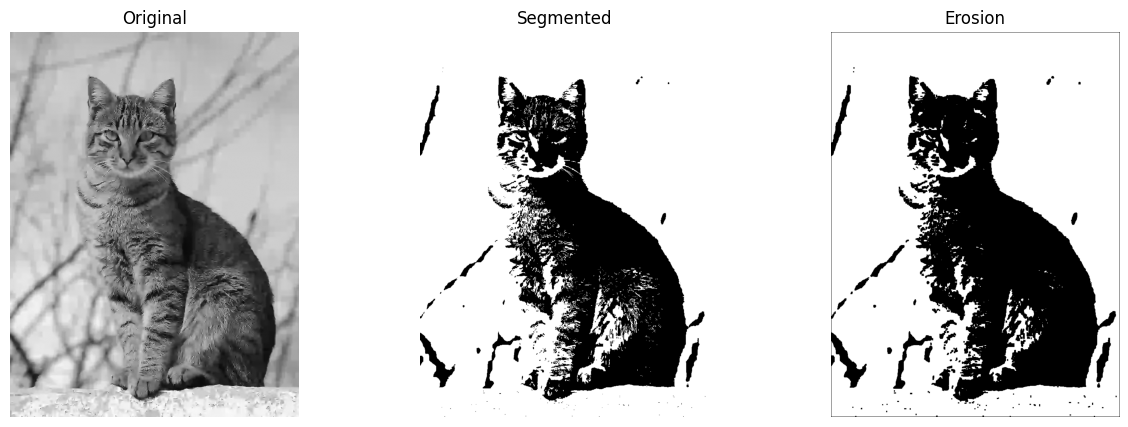

In [40]:
def erosion(img, kernel_size=3):
    rows, cols = img.shape
    eroded = np.zeros_like(img)
    kernel = np.ones((kernel_size, kernel_size), dtype=int)
    k_rows, k_cols = kernel.shape
    pad_rows, pad_cols = k_rows // 2, k_cols // 2

    padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)),
                    mode='constant', constant_values=0)

    for i in range(rows):
        for j in range(cols):
            region = padded[i:i+k_rows, j:j+k_cols]
            if np.all(region * kernel == 255):
                eroded[i, j] = 255
            else:
                eroded[i, j] = 0

    return eroded

eroded_img = erosion(segmented_img, kernel_size=3)
show(gray_img, segmented_img, eroded_img, title1="Original", title2="Segmented", title3="Erosion")


# **Dilation**
Dilasi merupakan proses morfologi yang bertujuan untuk memperbesar area foreground pada citra biner dengan cara menambahkan piksel di tepi objek menggunakan kernel atau structuring element. Proses ini membuat objek tampak lebih tebal dan menyatu, sehingga sangat berguna dalam kasus seperti Optical Character Recognition (OCR) pada dokumen historis yang memiliki karakter terputus. Dengan menerapkan dilasi, setiap karakter dapat tergabung menjadi satu bagian utuh sehingga citra lebih mudah diolah oleh sistem.

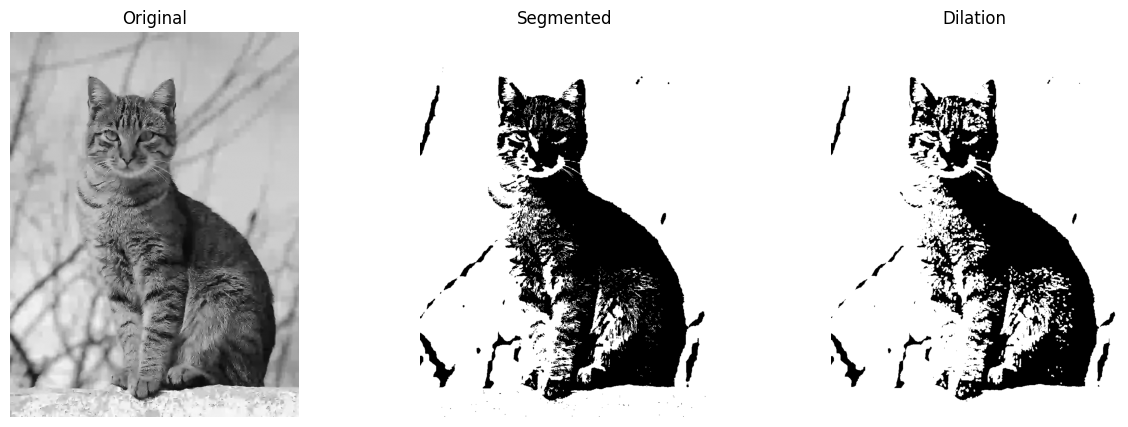

In [41]:
def dilation(img, kernel_size=3):
    rows, cols = img.shape
    dilated = np.zeros_like(img)
    kernel = np.ones((kernel_size, kernel_size), dtype=int)
    k_rows, k_cols = kernel.shape
    pad_rows, pad_cols = k_rows // 2, k_cols // 2

    padded = np.pad(img, ((pad_rows, pad_rows), (pad_cols, pad_cols)),
                    mode='constant', constant_values=0)

    for i in range(rows):
        for j in range(cols):
            region = padded[i:i+k_rows, j:j+k_cols]
            if np.any(region * kernel):
                dilated[i, j] = 255

    return dilated

dilated_img = dilation(segmented_img, kernel_size=3)
show(gray_img, segmented_img, dilated_img, title1="Original", title2="Segmented", title3="Dilation")

# **Opening**
Opening merupakan kombinasi dari dua operasi morfologi, yaitu erosi yang diikuti oleh dilasi. Tujuan utama dari metode ini adalah menghilangkan noise atau objek kecil yang tidak diinginkan tanpa mengubah bentuk utama objek. Pada tahap erosi, noise dihapus, kemudian dilasi mengembalikan ukuran objek agar tidak menyusut. Hasil akhirnya menghasilkan citra yang lebih bersih dengan bentuk objek utama tetap terjaga.


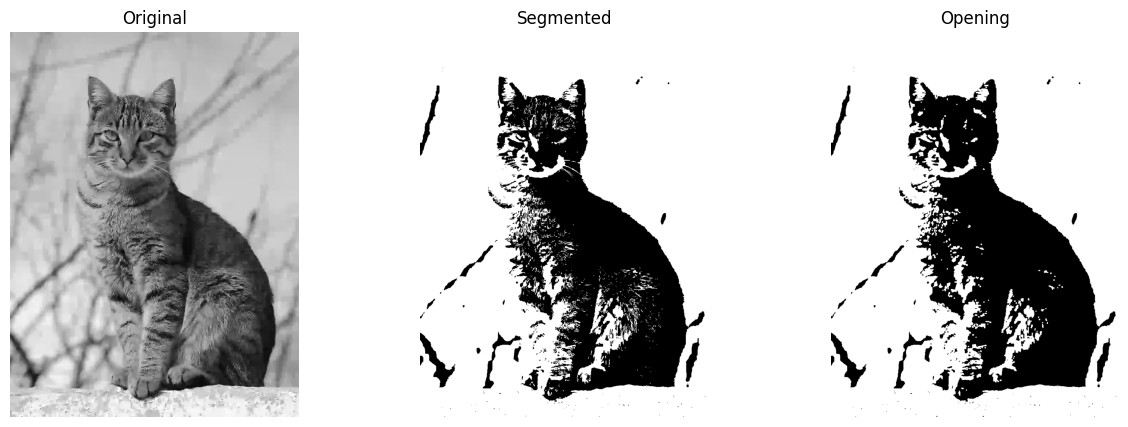

In [42]:
def opening(img, kernel_size=3):
    eroded = erosion(img, kernel_size)
    opened = dilation(eroded, kernel_size)
    return opened

opened_img = opening(segmented_img, kernel_size=3)
show(gray_img, segmented_img, opened_img, title1="Original", title2="Segmented", title3="Opening")

# **Closing**
Closing adalah kebalikan dari Opening, yaitu proses dilasi yang diikuti oleh erosi. Metode ini berfungsi untuk menutup celah atau lubang kecil pada objek hasil segmentasi sehingga objek tampak lebih utuh dan solid. Proses dilasi memperluas area foreground untuk menutup lubang, lalu erosi mengembalikan ukuran objek ke bentuk semula. Closing sering digunakan untuk memperbaiki citra dengan refleksi atau area kosong kecil agar hasil segmentasi menjadi lebih sempurna.




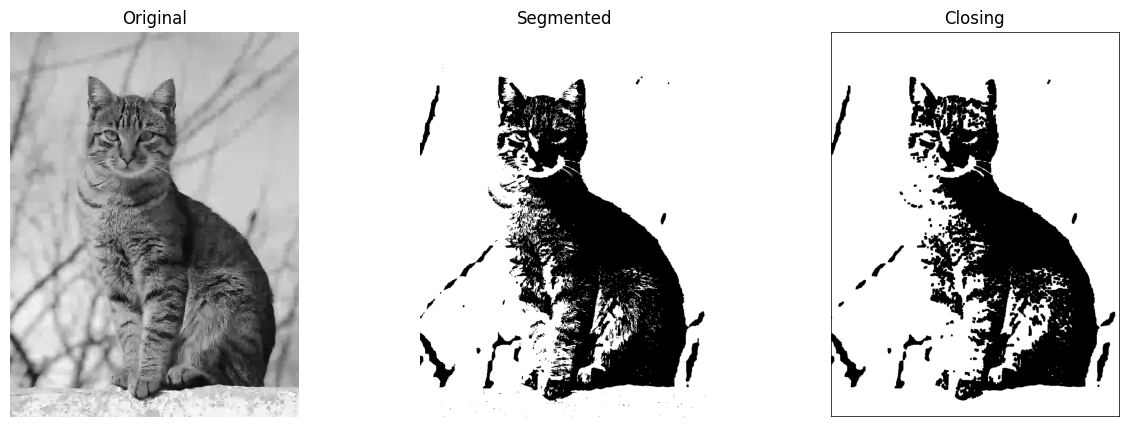

In [43]:
def closing(img, kernel_size=3):
    dilated = dilation(img, kernel_size)
    closed = erosion(dilated, kernel_size)
    return closed

closed_img = closing(segmented_img, kernel_size=5)
show(gray_img, segmented_img, closed_img, title1="Original", title2="Segmented", title3="Closing")